In [6]:
# Reproducibility, display, and versions
import warnings, os, sys
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

np.random.seed(42)
sns.set_theme(style='whitegrid')

In [7]:
DATA_PATH = "data.csv"
REQ_COLS = ["InvoiceNo","StockCode","Description","Quantity","InvoiceDate","UnitPrice","CustomerID","Country"]

assert os.path.exists(DATA_PATH), f"Missing file: {DATA_PATH}"
df = pd.read_csv(DATA_PATH, encoding="unicode_escape", low_memory=False)

missing = [c for c in REQ_COLS if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"


In [8]:
# Parse dtypes
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["CustomerID"] = df["CustomerID"].astype(str)
df["Description"] = df["Description"].astype(str).str.strip()


In [9]:
# Basic sanity
print(df.shape)
display(df.head(3))

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [10]:
# Drop invalid dates, missing customers
df = df.dropna(subset=["InvoiceDate"])
df = df[~df["CustomerID"].isin(["nan","None",""])]
# Remove cancellations (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
# Keep positive quantities and prices
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Normalize text
df["Description"] = (df["Description"]
                     .str.replace(r"\s+", " ", regex=True)
                     .str.encode("ascii", "ignore")
                     .str.decode("utf-8"))

# De-duplicate at transaction grain
dedup_keys = ["InvoiceNo","StockCode","Description","Quantity","UnitPrice"]
df = df.drop_duplicates(subset=dedup_keys)

# Monetary
df["TotalAmount"] = (df["Quantity"] * df["UnitPrice"]).astype("float64")

print("Post-clean shape:", df.shape)
display(df.describe(include="all").T.head(12))


Post-clean shape: (392691, 9)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
InvoiceNo,392691,18532,576339,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,392691,3665,85123A,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,392691,3858,WHITE HANGING HEART T-LIGHT HOLDER,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,392691.0,NaN,NaN,NaN,13.11973,1.0,2.0,6.0,12.0,80995.0,180.493061
InvoiceDate,392691,NaN,NaN,NaN,2011-07-10 19:12:52.404104192,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN
UnitPrice,392691.0,NaN,NaN,NaN,3.125917,0.001,1.25,1.95,3.75,8142.75,22.241864
CustomerID,392691,4338,17841.0,7676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,392691,37,United Kingdom,349202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalAmount,392691.0,NaN,NaN,NaN,22.631547,0.001,4.95,12.45,19.8,168469.6,311.099619


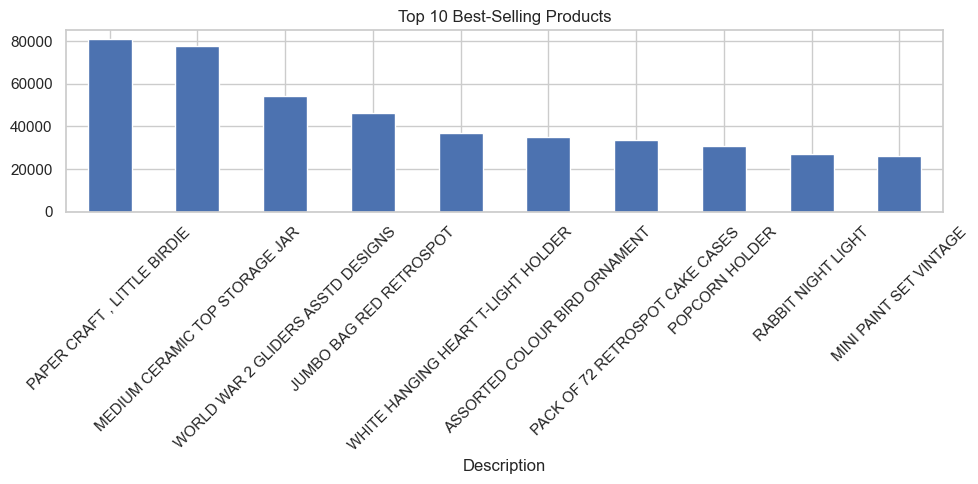

In [11]:
# Top products
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
ax = top_products.plot(kind="bar", figsize=(10,5), title="Top 10 Best-Selling Products")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

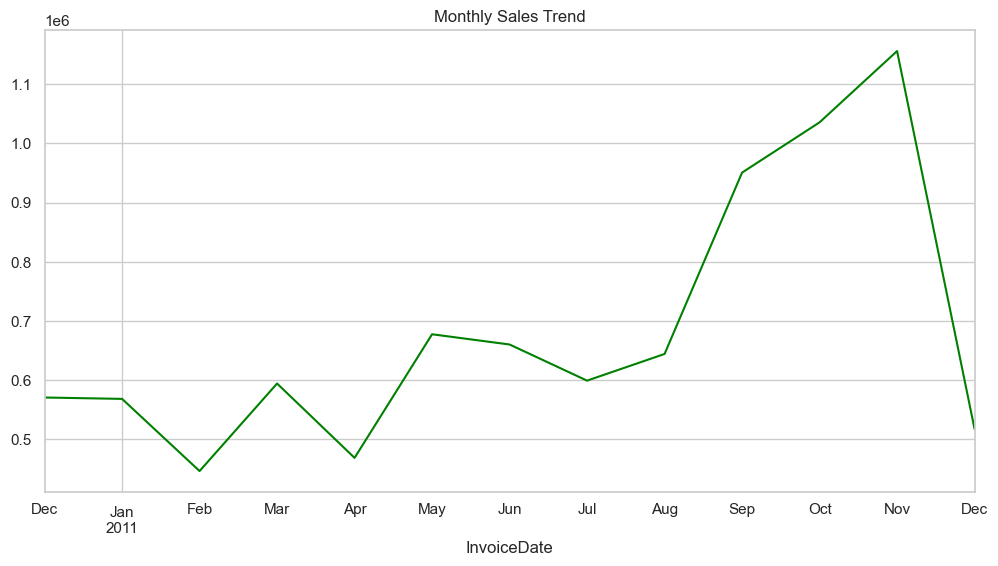

In [12]:
#sales Trends
sales_per_month = df.set_index('InvoiceDate').resample('M')['TotalAmount'].sum()
sales_per_month.plot(figsize=(12,6), title="Monthly Sales Trend", color='green')
plt.show()


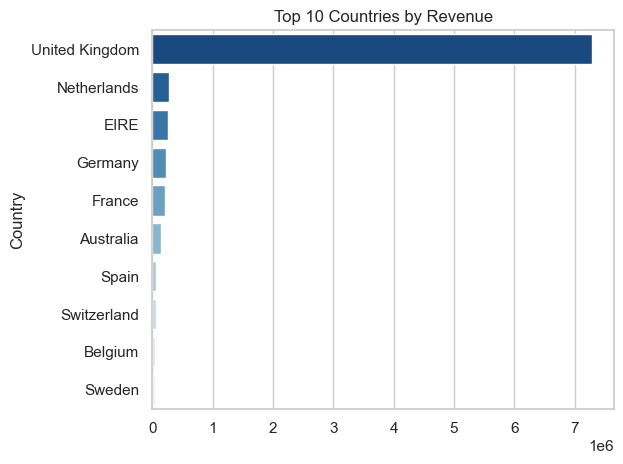

In [13]:
# Country revenue
country_sales = df.groupby("Country")["TotalAmount"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=country_sales.values, y=country_sales.index, palette="Blues_r")
plt.title("Top 10 Countries by Revenue")
plt.tight_layout()
plt.show()

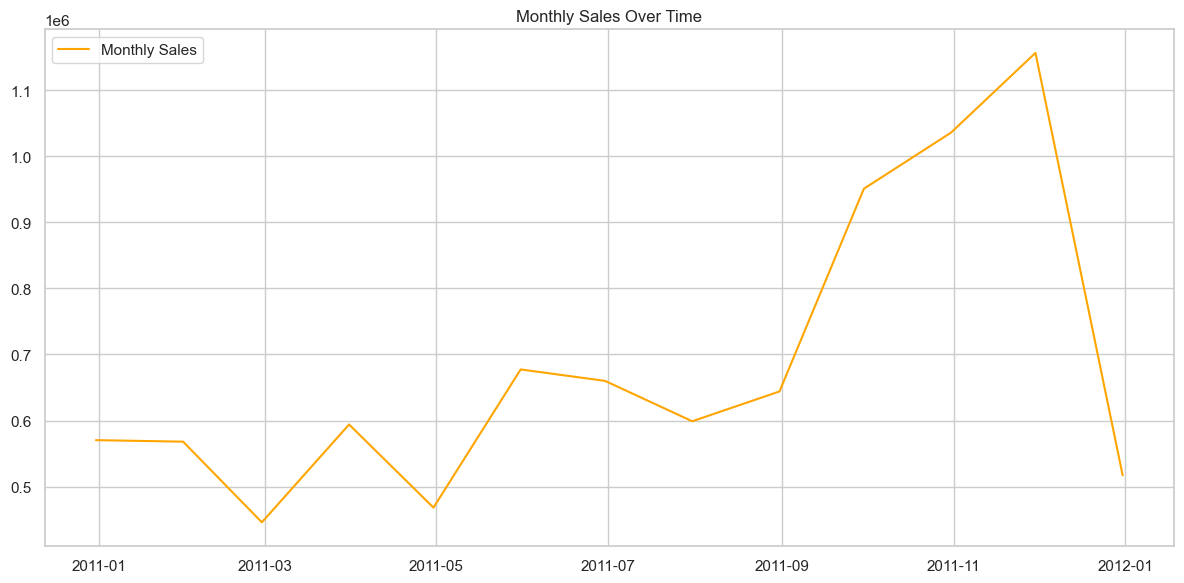

In [14]:
monthly_sales = (df.set_index("InvoiceDate")
                   .resample("M")["TotalAmount"].sum()
                   .asfreq("M").fillna(0))

plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label="Monthly Sales", color="orange")
plt.title("Monthly Sales Over Time")
plt.legend(); plt.tight_layout(); plt.show()

Chosen k (max silhouette): 4


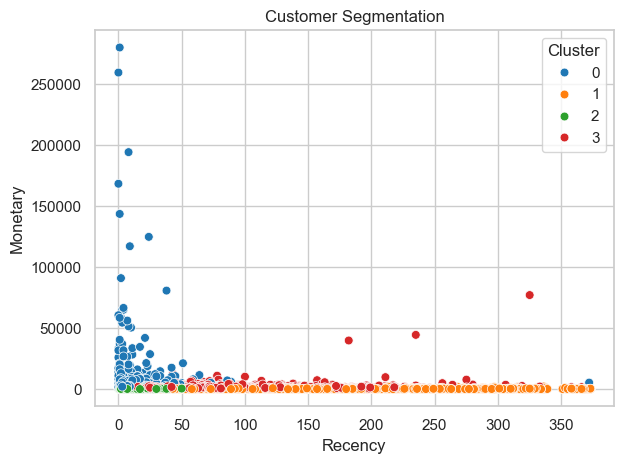

In [15]:
analysis_date = df["InvoiceDate"].max().normalize()

rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (analysis_date - x.max().normalize()).days),
    Frequency=("InvoiceNo","nunique"),
    Monetary=("TotalAmount","sum")
).astype({"Recency":"int64","Frequency":"int64","Monetary":"float64"})

# Log-transform skewed dimensions except Recency >= 1 shift
rfm_tf = rfm.copy()
rfm_tf["Recency"] = np.log1p(rfm_tf["Recency"])  # lower is better, transform for scale
rfm_tf["Frequency"] = np.log1p(rfm_tf["Frequency"])
rfm_tf["Monetary"] = np.log1p(rfm_tf["Monetary"].clip(lower=0))

scaler = StandardScaler()
X = scaler.fit_transform(rfm_tf)

# K tuning with elbow + silhouette
inertias, sils, ks = [], [], range(4, 9)
for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

best_k = int(ks[int(np.argmax(sils))])
print("Chosen k (max silhouette):", best_k)

kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(X)

sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="tab10", s=40)
plt.title("Customer Segmentation")
plt.tight_layout(); plt.show()

rfm_out = rfm.reset_index()
rfm_out.to_csv("rfm_clusters.csv", index=False)


In [16]:
# Basket at invoice level, excluding cancellations already filtered
basket_qty = (df.groupby(["InvoiceNo","Description"])["Quantity"]
                .sum().unstack(fill_value=0))

# Binary presence matrix (sparse-friendly conversion)
basket_sets = (basket_qty > 0).astype("uint8")

# drop extremely rare items to reduce dimensionality
min_item_support = 0.01
item_support = basket_sets.mean(axis=0)
keep_cols = item_support[item_support >= min_item_support].index
basket_sets = basket_sets[keep_cols]



In [17]:
# Frequent itemsets and rules
freq = apriori(basket_sets, min_support=0.02, use_colnames=True)
rules = association_rules(freq, metric="confidence", min_threshold=0.3)
rules = rules[(rules["lift"] > 1)].sort_values(["lift","confidence"], ascending=False)

rules_simple = rules.loc[:, ["antecedents","consequents","support","confidence","lift"]].head(20)
display(rules_simple)

rules_simple.to_csv("assoc_rules_top20.csv", index=False)



,antecedents,consequents,support,confidence,lift
67,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.021045,0.701439,24.027846
66,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.021045,0.720887,24.027846
64,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.021045,0.894495,23.989564
69,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.021045,0.564399,23.989564
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.024822,0.827338,22.188466
9,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.024822,0.665702,22.188466
65,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.021045,0.847826,20.066300
68,(ROSES REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.021045,0.498084,20.066300
58,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.023527,0.784173,18.559754
59,(ROSES REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.023527,0.556833,18.559754


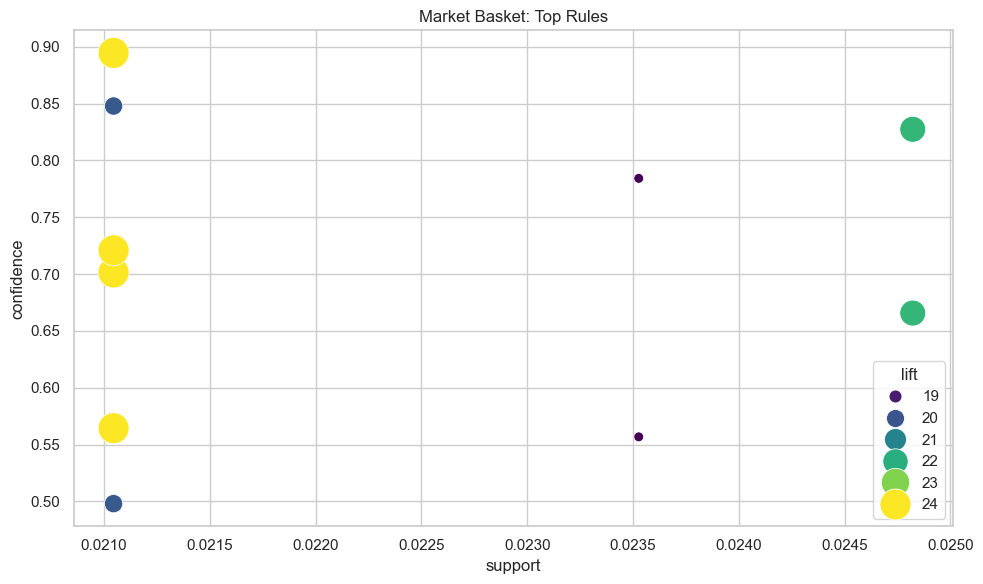

In [18]:

# Quick scatter of top rules
top_rules = rules.head(10)
plt.figure(figsize=(10,6))
sns.scatterplot(data=top_rules, x="support", y="confidence", size="lift", hue="lift", sizes=(50, 500), palette="viridis")
plt.title("Market Basket: Top Rules")
plt.tight_layout(); plt.show()